In [1]:
from math import ceil
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from basis_expansions import NaturalCubicSpline
from dftransformers import (ColumnSelector, Identity,
                            FeatureUnion, MapFeature,
                            Intercept)
from regression_helpers import (plot_univariate_smooth,
                                bootstrap_train,
                                display_coef,
                                plot_bootstrap_coefs,
                                plot_partial_depenence,
                                predicteds_vs_actuals)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/matthewdrury/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
concrete = pd.read_excel('Concrete_Data.xls')
print(concrete.shape)

(1030, 9)


In [3]:
concrete.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
column_names_raw = concrete.columns
print(column_names_raw)

Index([u'Cement (component 1)(kg in a m^3 mixture)',
       u'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       u'Fly Ash (component 3)(kg in a m^3 mixture)',
       u'Water  (component 4)(kg in a m^3 mixture)',
       u'Superplasticizer (component 5)(kg in a m^3 mixture)',
       u'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       u'Fine Aggregate (component 7)(kg in a m^3 mixture)', u'Age (day)',
       u'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')


In [5]:
column_names = [
    'cement',
    'blast_furnace_slag',
    'fly_ash',
    'water',
    'superplasticizer',
    'coarse_aggregate',
    'finite_aggregate',
    'age',
    'compressive_strength',
]
concrete.columns = column_names

In [6]:
concrete.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,finite_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


## Exploratory Data Analysis and Model Specification

In [7]:
#_ = scatter_matrix(concrete, alpha=0.2, figsize=(20, 20), diagonal='kde')

/Users/matthewdrury/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


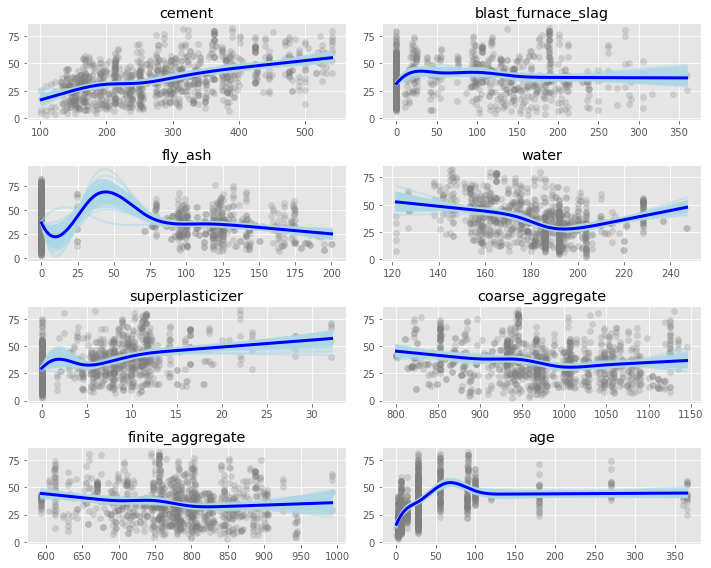

In [8]:
fig, axs = plt.subplots(4, 2, figsize=(10, 8))
univariate_plot_names = concrete.columns[:-1]

for name, ax in zip(univariate_plot_names, axs.flatten()):
    plot_univariate_smooth(ax, 
                           concrete[name].values.reshape(-1, 1),
                           concrete['compressive_strength'],
                           bootstrap=100)
    ax.set_title(name)
fig.tight_layout()

## How Will We Treat These Varaibles in Regression

Let's look through each of these plots for evidence on how to treat these features in a regression model.

In [9]:
def plot_one_univariate(ax, var_name, mask=None):
    if mask is None:
        plot_univariate_smooth(
            ax,
            concrete[var_name].values.reshape(-1, 1), 
            concrete['compressive_strength'],
            bootstrap=200)
    else:
        plot_univariate_smooth(
            ax,
            concrete[var_name].values.reshape(-1, 1), 
            concrete['compressive_strength'],
            mask=mask,
            bootstrap=200)

### Cement

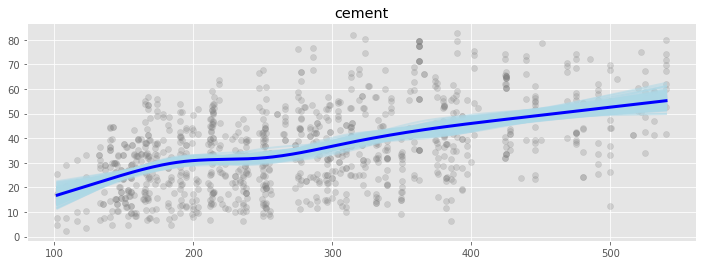

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_one_univariate(ax, "cement")
ax.set_title("cement")

There is not much evidence that fitting anything other than a line is justified, but we can always be fooled with a univariate look at the data.
Let's go with a fit with a small amount of flexibility.  Three knots will allow the fit to have a different incoming and outgoing slope.

In [11]:
cement_fit = Pipeline([
    ('cement', ColumnSelector(name='cement')),
    ('cement_spline', NaturalCubicSpline(knots=[200, 300, 400]))
])

### Blast Furnace Slag

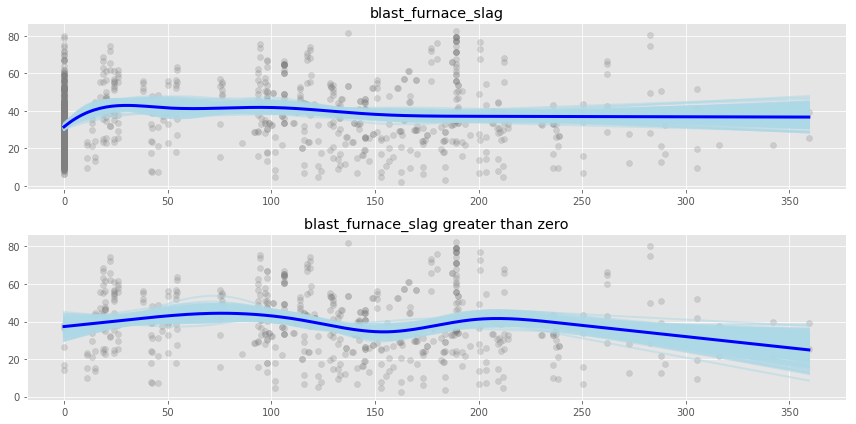

In [12]:
fig, axs = plt.subplots(2, figsize=(12, 6))

plot_one_univariate(axs[0], "blast_furnace_slag")
axs[0].set_title("blast_furnace_slag")

plot_one_univariate(axs[1], "blast_furnace_slag", 
                    mask=(concrete['blast_furnace_slag'] > 0))
axs[1].set_title("blast_furnace_slag greater than zero")
fig.tight_layout()

There is a lot of data with value zero, and this seems to be associated with a lower value of `y` than would otherwise be expected.  

The rest of the data does not tell a straightforward story.  There *may* be a trend, but there may not.  In doublt, let's give the model some flexibility, which we can walk back leter if we end up not needing it.

Taking this into account, we will fit this feature using an indicator varaible, and a spline to :

  - An indicator varaible for `blast_furnace_slag == 0`.
  - A spline for the overall trend of `blast_furnace_slag`.
  
This also brings up an interesting **inferential** question that we may want to study in the future: is the effect of `blast_furnace_slag` non-zero?

In [13]:
slag_fit = Pipeline([
    ('slag', ColumnSelector(name='blast_furnace_slag')),
    ('slag_features', FeatureUnion([
        ('zero_slag', MapFeature(lambda slag: slag == 0.0, 'zero_slag')),
        ('slag_spline', NaturalCubicSpline(knots=[35, 60, 150, 200, 250]) )  
    ]))
])

### Fly Ash

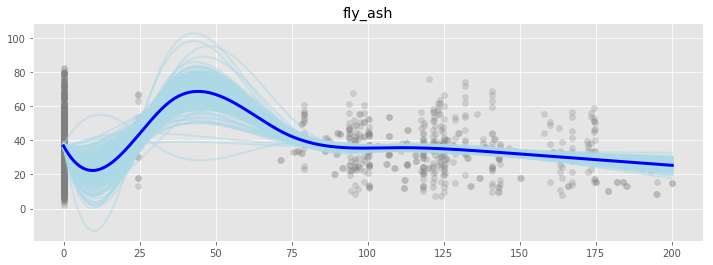

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_one_univariate(ax, "fly_ash")
ax.set_title("fly_ash")

Another similar case to the `blast_furnace_slag`, there is a stong cluster of records with a value of zero.  

There is not much evidence for anything more complicated than linear variation in the large cluster of data to the right of the plot (in the `>= 75` reigon).

The small cluster at `25` seems innocent, but the are *high leverage* points.  If we leave them unattended to, they may exhibit a large effect on the slope of the regression line we hope to fit to the rest of the data.  For this reason, we will also add an indicator varaible for `fly_ash == 25.0`.

In [15]:
fly_ash_fit = Pipeline([
    ('fly_ash', ColumnSelector(name='fly_ash')),
    ('fly_ash_features', FeatureUnion([
        ('zero_fly_ash', MapFeature(lambda ash: ash == 0.0, 'zero_fly_ash')),
        ('twenty_five_fly_ash', MapFeature(
            lambda ash: (ash >= 24.0) & (ash <= 26.0), 'twenty_five_fly_ash')),
        ('fly_ash', NaturalCubicSpline(knots=[100, 125, 150]))  
    ]))
])

### Water

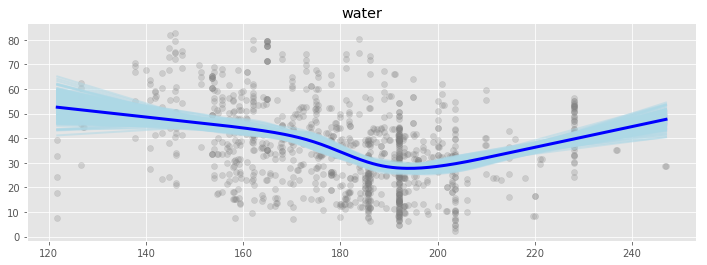

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_one_univariate(ax, "water")
ax.set_title('water')

Water is an interesting feature.  It looks like too little water harms the compressive strength of a concrete, as does too mych water, with a perfect level somewhere in the middle.  It looks like the engeneers *know* this, as evidenced by the large accumulation of points at around `190`, which is very close to the sweet spot.

We would like to capture this trend, which requires three degrees of freedom, and hence three knots (you can convince yourself of this by playing with the smoothers app.

In [17]:
water_fit = Pipeline([
    ('water', ColumnSelector(name='water')),
    ('water_spline', NaturalCubicSpline(knots=[170, 190, 210]))
])

### Superplasticizer

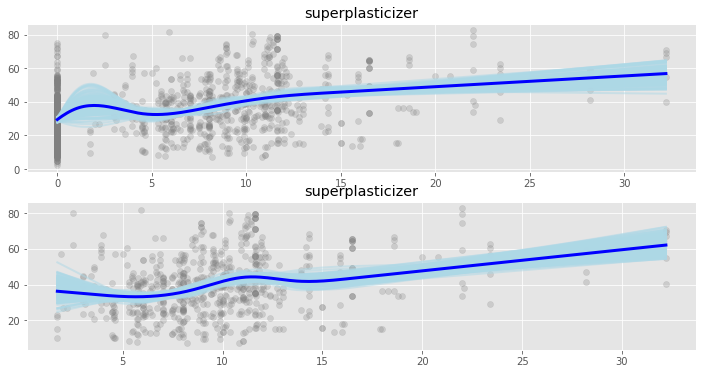

In [18]:
fig, axs = plt.subplots(2, figsize=(12, 6))

plot_one_univariate(axs[0], "superplasticizer")
axs[0].set_title('superplasticizer')

plot_one_univariate(axs[1], "superplasticizer",
                    mask=(concrete['superplasticizer'] > 0))
axs[1].set_title('superplasticizer')

Here, again, we need an indicator varaible for the many records which assume that value zero.

For the non-zero records, it looks like there may be some non-linearity in the trend, flatter ...

In [19]:
superplasticizer_fit = Pipeline([
    ('superplasticizer', ColumnSelector(name='superplasticizer')),
    ('superplasticizer_features', FeatureUnion([
        ('zero_superplasticizer', 
            MapFeature(lambda plast: plast == 0.0, 'zero_superplasticizer')),
        ('superplasticizer_spline', 
            NaturalCubicSpline(knots=[5, 10, 15]) )  
    ]))
])

### Course Aggregate

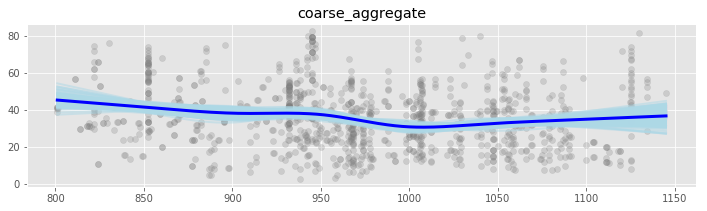

In [20]:
fig, ax = plt.subplots(figsize=(12, 3))

plot_one_univariate(ax, "coarse_aggregate")
ax.set_title('coarse_aggregate')

Looks like a clear cut three knots situation.

In [21]:
coarse_agg_fit = Pipeline([
    ('coarse_agg', ColumnSelector(name='coarse_aggregate')),
    ('course_add_spline', NaturalCubicSpline(knots=[900, 975, 1050]))
])

### Finite Aggregate

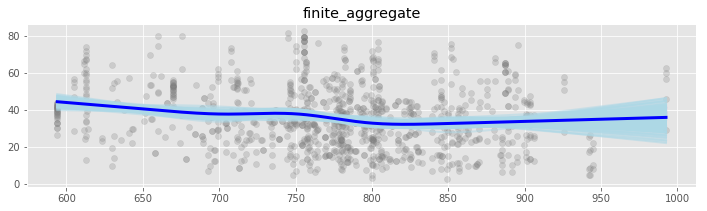

In [22]:
fig, ax = plt.subplots(figsize=(12, 3))

plot_one_univariate(ax, "finite_aggregate")
ax.set_title('finite_aggregate')

In [23]:
finite_agg_fit = Pipeline([
    ('finite_agg', ColumnSelector(name='finite_aggregate')),
    ('finite_add_spline', NaturalCubicSpline(knots=[900, 975, 1050]))
])

### Age

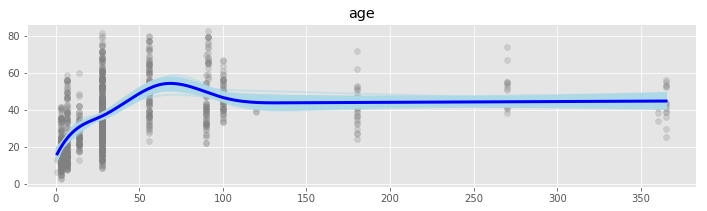

In [24]:
fig, ax = plt.subplots(figsize=(12, 3))

plot_one_univariate(ax, "age")
ax.set_title('age')

In [25]:
age_fit = Pipeline([
    ('age', ColumnSelector(name='age')),
    ('finite_add_spline', NaturalCubicSpline(knots=[20, 50, 100, 150]))
])

### A Possible Issue

### Constructing All the Features

In [26]:
feature_pipeline = FeatureUnion([
    ('intercept', Intercept()),
    ('cement_fit', cement_fit),
    ('slag_fit', slag_fit),
    ('fly_ash_fit', fly_ash_fit),
    ('water_fit', water_fit),
    ("superplasticizer_fit", superplasticizer_fit),
    ("coarse_agg_fit", coarse_agg_fit),
    ("finite_agg_fit", finite_agg_fit),
    ("age_fit", age_fit)
])

In [27]:
feature_pipeline.fit(concrete)
features = feature_pipeline.transform(concrete)

In [ ]:
features.head()

,intercept,cement_spline_linear,cement_spline_0,zero_slag,blast_furnace_slag_spline_linear,blast_furnace_slag_spline_0,blast_furnace_slag_spline_1,blast_furnace_slag_spline_2,zero_fly_ash,twenty_five_fly_ash,...,zero_superplasticizer,superplasticizer_spline_linear,superplasticizer_spline_0,coarse_aggregate_spline_linear,coarse_aggregate_spline_0,finite_aggregate_spline_linear,finite_aggregate_spline_0,age_spline_linear,age_spline_0,age_spline_1
0,1.0,540.0,72000.000000,1.0,0.0,0.000000,0.000000,0.0,1.0,0.0,...,0.0,2.5,0.0,1040.0,14631.666667,676.0,0.0,28.0,3.938462,0.0
1,1.0,540.0,72000.000000,1.0,0.0,0.000000,0.000000,0.0,1.0,0.0,...,0.0,2.5,0.0,1055.0,18000.000000,676.0,0.0,28.0,3.938462,0.0
2,1.0,332.5,11287.734375,0.0,142.5,5778.125000,2955.345395,0.0,1.0,0.0,...,1.0,0.0,0.0,932.0,218.453333,594.0,0.0,270.0,43200.000000,25500.0
3,1.0,332.5,11287.734375,0.0,142.5,5778.125000,2955.345395,0.0,1.0,0.0,...,1.0,0.0,0.0,932.0,218.453333,594.0,0.0,365.0,66000.000000,39750.0
4,1.0,198.6,0.000000,0.0,132.4,4297.722902,1997.386442,0.0,1.0,0.0,...,1.0,0.0,0.0,978.4,3212.077973,825.5,0.0,360.0,64800.000000,39000.0


## Fitting a Regression and Investigating the Results

In [ ]:
model = LinearRegression(fit_intercept=False)
model.fit(features.values, y=concrete['compressive_strength'], )

In [ ]:
display_coef(model, features.columns)

### Bootstrap to Get a Feel for How the Coefficients Vary

In [ ]:
models = bootstrap_train(
    LinearRegression, features.values, concrete['compressive_strength'],
    fit_intercept=False
)

In [ ]:
fig, axs = plot_bootstrap_coefs(models, features.columns)
fig.tight_layout()

### Patial Dependence Plots for the Fit Effect of a Predictor

In [ ]:
def plot_partial_dependences(model, X, var_names, 
                            y=None, bootstrap_models=None, pipeline=None, n_points=250):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        if bootstrap_models:
            for M in bootstrap_models[:100]:
                plot_partial_depenence(
                    ax, M, X=X, var_name=name, pipeline=pipeline, alpha=0.8, 
                    linewidth=1, color="lightblue")
        plot_partial_depenence(ax, model, X=X, var_name=name, y=y,
                               pipeline=pipeline, color="blue", linewidth=3)
        ax.set_title("{} Partial Dependence".format(name))
    return fig, axs

In [ ]:
var_names = ["cement", "blast_furnace_slag", "fly_ash", 
             "water", "superplasticizer", "coarse_aggregate",
             "finite_aggregate", "age"]
fig, axs = plot_partial_dependences(
     model, 
     X=concrete,
     var_names=var_names,
     pipeline=feature_pipeline,
     bootstrap_models=models,
     y=concrete["compressive_strength"])
fig.tight_layout()

### Predicted vs. Actuals by Varaibles

In [ ]:
def plot_many_predicteds_vs_actuals(var_names, y_hat, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = concrete[name]
        predicteds_vs_actuals(ax, x, concrete["compressive_strength"], y_hat)
        ax.set_title("{} Predicteds vs. Actuals".format(name))
    return fig, axs

In [ ]:
y_hat = model.predict(features)

In [ ]:
var_names = ["cement", "blast_furnace_slag", "fly_ash", 
             "water", "superplasticizer", "coarse_aggregate",
             "finite_aggregate", "age"]
fig, axs = plot_many_predicteds_vs_actuals(var_names, y_hat)
fig.tight_layout()

### Residuals by Varaible

In [ ]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)

In [ ]:
def plot_many_residuals(var_names, y_hat, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = concrete[name]
        residual_plot(ax, x, concrete["compressive_strength"], y_hat)
        ax.set_title("Model Residuals by {}".format(name))
    return fig, axs

In [ ]:
var_names = ["cement", "blast_furnace_slag", "fly_ash", 
             "water", "superplasticizer", "coarse_aggregate",
             "finite_aggregate", "age"]
fig, axs = plot_many_residuals(var_names, y_hat)
fig.tight_layout()